In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score, accuracy_score
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import time
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
#import xgboost as xgb
from sklearn.model_selection import cross_val_score,StratifiedKFold
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.cross_decomposition import PLSRegression
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.feature_selection import f_regression, SelectKBest, VarianceThreshold, SelectFromModel
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression
import datetime as dt
from scipy import stats
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans, MeanShift
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
import matplotlib.cm

# Definitions

In [ ]:
def rf_init():
    return RandomForestRegressor()

def percent_nans(column, dataframe):
    return len(dataframe[dataframe[column].isna()])/len(dataframe)

class TrainingManager(object):
    """
    ###target can be (lethality, survival, cum_positive_density, cum_deceased_density, cum_recovered_density)
    new target can be: lethality_rate (cumulated_deceased/cumulated_positives) , 
                    survival_rate (cumulated_recovered/cumulated_positives)
    """
    def __init__(self, ml_dataset_file_path, 
                 features=None,
                 target="cum_deceased_density",
                 prob_type="classification"):
        
        #assert target in ["cum_positive_density", "cum_deceased_density", "cum_recovered_density"], 'Error, target must be in ["cum_positive_density", "cum_deceased_density", "cum_recovered_density"]'
        #assert target in ["lethality_rate", "survival_rate"], 'Error, target must be in ["lethality_rate", "survival_rate"]'
        p_types = ["regression", "classification"]
        assert prob_type in p_types, f'Error, found problem type = "{prob_type}" but available are {p_types}'
        self.prob_type = prob_type
        
        self.population_dependent_features = ["farm_labour_force.tsv","available_hospital_beds_nuts2.tsv",
                "deaths.tsv",
                "hospital_discharges_resp_diseases_j00_to_j99_nuts2.tsv",
                "stock_of_vehicles_by_category_and_nuts2.tsv",
                "employment_thousand_hours_worked_nuts2.tsv",
                "stock_of_vehicles_by_category_and_nuts2.tsv",
                "students_enrolled_in_tertiary_education_by_education_level_programme_orientation_sex_and_nuts2.tsv",
                "health_personnel_by_nuts2.tsv",
                "pupils_and_students_enrolled_by_sex_age_and_nuts2.tsv",
                "early_leavers_from_education_and_training_by_sex_percentage_nuts2.tsv"]
        
        
        target_origin = target.replace("_density", "")
        self.target = target
        df = pd.read_csv(ml_dataset_file_path, sep="\t", index_col=0)
        # check that target is correctly reported(some state reported 0 as deceased or recovered, 
        # but with large numbers of positives it clearly can't be the case for the 'cumulated target'(the target origin from which the density is computed) )
        df = df[ (df[target_origin].isna() == False) & (df[target_origin] > 0.)  ] 
        
        self.df = df
        
        
        
        #X = df.iloc[:,11:-3 ]
        features_to_remove = ['cum_positive', 'cum_deceased', 'cum_recovered', 'curr_positive',
        'hospitalized', 'intensive_care', 'iso3', 'country_name', 'EUCountry',
        'EUCPMCountry', 'date', 
        'cum_positive_density', 'cum_deceased_density', 'cum_recovered_density',
        #'cluster_id', 'cum_positive_density_severity'
                             ]
        
        X = df.drop(labels=features_to_remove, axis="columns")
        
        
        national_means = pd.DataFrame()
        national_means[X.columns] = X[X.columns]
        # fill with national mean where possible
        national_means["iso3"] = df["iso3"]
        national_means = national_means.groupby(by="iso3" ).mean()

        iso3_aggregator_df = pd.DataFrame()
        iso3_aggregator_df["iso3"] = df[ "iso3" ]
        iso3_aggregator_df["nuts"] = iso3_aggregator_df.index
        iso3_aggregator_df = iso3_aggregator_df.merge(national_means, left_on="iso3", right_on="iso3")
        iso3_aggregator_df.set_index("nuts", inplace=True)
    
        for column in X.columns:
            X[column].fillna(iso3_aggregator_df[column], inplace=True)
            
            
        
        
        if features is not None:
            X = X[features]
            
        
        #if target == "lethality_rate":
        #    y = df["cum_deceased_density"]*100 / df["cum_positive_density"]
        #elif target == "survival_rate":
        #    y = df["cum_recovered_density"]*100 / df["cum_positive_density"]
        
        
        if self.prob_type == "regression":
            y = df[target] *100
        else:
            #"classification"
            res_response_target_name, res_response_series = self.__clusterize_target( response_variable="cum_positive_density")
            y = pd.Series(res_response_series, name ="res_response_target_name")
            
        #y = df[target] *100 / df["cum_positive_density"]
    
        
        self.X = X
        self.y = y
        
        self.shuffle = True
        self.test_size = 0.3
    def __clusterize_target(self, response_variable="cum_positive_density"):
            avbl_responses = ["cum_positive_density", "cum_deceased_density", "cum_recovered_density"]
            assert response_variable in avbl_responses, f"Error {response_variable} not in {avbl_responses}"


            X = self.df[response_variable]

            X = X.to_numpy().reshape(-1,1)
            X = np.where(np.isnan(X), X[ np.isnan(X)==False].mean(axis=0), X)

            kmeans = KMeans(n_clusters=3)
            cluster = kmeans.fit(X)

            from collections import Counter
            counter = Counter(cluster.labels_)
            clust_df = self.df.copy()
            clust_df["cluster_id"] = cluster.labels_
            # obtain the mapping from cluster id to mean feature value
            # this allows to sort the cluster ids from lowest to highest severity
            # since cluster ids are NOT necessarily assigned in increasing order of the underlying feature
            sorted_clust_id_by_mean_dict = clust_df.groupby(by="cluster_id")[response_variable].mean().sort_values().to_dict()


            cluster_labels = ["low", "medium", "high"]
            clusterid_to_categorical_mapping = dict()
            categorical_to_clusterid_mapping = dict()

            for item, label in zip(sorted_clust_id_by_mean_dict.items(), cluster_labels):
                clusterid, feature_mean = item
                clusterid_to_categorical_mapping[clusterid] = label
                categorical_to_clusterid_mapping[label] = clusterid


            clust_df[response_variable + "_severity"] = clust_df["cluster_id"].map(clusterid_to_categorical_mapping)

            res_response_target_name = response_variable + "_severity"
            res_response_series = clust_df["cluster_id"].map(clusterid_to_categorical_mapping)

            return res_response_target_name, res_response_series
    
    
    
    def __remove_population_dependency(self):
        for column in self.population_dependent_features:
            self.X[column] = self.X[column] / self.X["population_nuts2.tsv"]
        #self.X[self.population_dependent_features] = self.X[self.population_dependent_features] / self.X["population_nuts2.tsv"]
    def __fillnans(self):
        self.X.fillna(self.X.mean(axis=0), inplace=True)
    def __standardize(self):
        # could standardize after splitting for technicalities of data leak of the dataset statistics
        self.X_mean = self.X.mean(axis=0)
        self.X_std = self.X.std(axis=0)
        self.X = (self.X - self.X.mean(axis=0))/ self.X.std(axis=0)
        
        
    def __train_test_split(self, test_size=0.3, shuffle=True):
        self.test_size = test_size
        self.shuffle = shuffle
        
        self.X_train_full, self.X_test, self.y_train_full, self.y_test = train_test_split(self.X, self.y, test_size=test_size, shuffle=shuffle)
        
    
    def __set_model(self, model):
        """
        pass as parameter a scikit-learn like model that supports the scikit fit, predict interfaces 
        """
        self.model = model
        # threshold for the feature selection is computed as the mean of the feature importances 
        # this can be read from the docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html#sklearn.feature_selection.SelectFromModel
        
        if self.prob_type == "regression":
            selector_helper = RandomForestRegressor()
        else:
            selector_helper = RandomForestClassifier()
        self.pipeline = Pipeline( steps= [('feature_selection', SelectFromModel(selector_helper )),
                                          ("model",model)#RandomForestRegressor())#xgb.XGBRegressor(n_estimators=200, max_depth=5)),
                                                     ])
    def __set_cv(self, n_splits=10):
        self.n_splits = n_splits
        self.kf = KFold(n_splits=n_splits)
        
        
        
    def train_test(self,model, metric, test_size=0.3, shuffle=True,n_splits=10):
        self.__fillnans()
        self.__remove_population_dependency()
        #self.__standardize()
        self.__train_test_split(test_size=test_size, shuffle=shuffle)
        self.__set_model(model)
        self.__set_cv(n_splits=n_splits)
        

        tot_train_score = 0
        tot_valid_score = 0
        tot_test_score = 0
        for train_index, valid_index in self.kf.split(self.X_train_full):

            #print("TRAIN:", train_index, "TEST:", valid_index)
            X_train, X_valid = self.X_train_full.iloc[train_index], self.X_train_full.iloc[valid_index]
            y_train, y_valid = self.y_train_full.iloc[train_index], self.y_train_full.iloc[valid_index]


           
            self.pipeline.fit(X_train, y_train)

            #cross_v
            y_train_preds = self.pipeline.predict(X_train)
            y_valid_preds = self.pipeline.predict(X_valid)
            y_test_preds = self.pipeline.predict(self.X_test)
 
            
            if metric == f1_score:
                tot_train_score += metric(y_train, y_train_preds, average="weighted")
                tot_valid_score += metric(y_valid, y_valid_preds, average="weighted")
                tot_test_score += metric(self.y_test, y_test_preds, average="weighted")
            else:
                tot_train_score += metric(y_train, y_train_preds)
                tot_valid_score += metric(y_valid, y_valid_preds)
                tot_test_score += metric(self.y_test, y_test_preds)
        #print("Train: ", tot_train_score/n_splits) 
        #print("Valid: ", tot_valid_score/n_splits)
        #print("Test: ", tot_test_score/n_splits)

        self.trained_model = self.pipeline["model"]
        
        return {"Train": tot_train_score/n_splits, 
                "Validation": tot_valid_score/n_splits,
                "Test": tot_test_score/n_splits}
    
    def longrun_train_test(self, model_init_fn=rf_init,
                           metric=mean_absolute_error,
                           num_runs=20,
                          test_size=0.2):
        from tqdm import tqdm        

    
        longrun_fimp_dict = dict()
        for i in tqdm(range(num_runs)):
            self.train_test(model_init_fn(), metric=metric,test_size=test_size)


            selected_features = self.X_train_full.columns[self.pipeline["feature_selection"].get_support()]    
            feature_importances = sorted(zip(selected_features, self.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
            for feature, importance in feature_importances:
                #print(feature, " ", importance)
                if feature not in longrun_fimp_dict:
                    longrun_fimp_dict[feature] = [importance]
                else:
                    longrun_fimp_dict[feature].append(importance)
        res = dict()
        for feature, importances in  longrun_fimp_dict.items():
            res[feature] = (sum(importances)/len(importances), len(importances))
        return res#sorted(res.items(), key=lambda x: x[1][0], reverse=True)
    

        
    
    
    
    


# Analysis

In [28]:

    
    
target = "cum_positive_density"
tm = TrainingManager("ml_dataset.tsv", target=target) 


svm_param_grid = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
rf_param_grid = {
 'max_depth': [5, 10],
 'max_features': ['auto', 'sqrt'],
 'n_estimators': [100, 400],
#     'bootstrap': [True, False],
#     'min_samples_leaf': [1, 2, 4],
# 'min_samples_split': [2, 5, 10],            
    }
estimator_svc = SVC()
estimator_rf = RandomForestClassifier()



gs = GridSearchCV(estimator_rf, param_grid=rf_param_grid, refit=True, cv=5)
    

training_metrics = tm.train_test( gs,#LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000),#RandomForestClassifier(),
                                 metric=f1_score,test_size=0.2)

selected_features = tm.X_train_full.columns[tm.pipeline["feature_selection"].get_support()]   


def print_feature_importances(selected_features, tm):
    feature_importances = sorted(zip(selected_features, tm.trained_model.feature_importances_), key=lambda x: x[1], reverse=True )
    for feature, importance in feature_importances:
        print(feature, " ", importance)
print_feature_importances(selected_features, tm)

training_metrics

{'Train': 0.30741405525838156,
 'Validation': 0.3237641280288338,
 'Test': 0.20020020020020018}

# Result exploration

## robustness ofthe feature selection

In [8]:
N_RUNS=20
def rf_clf_init():
    return RandomForestClassifier()
res = tm.longrun_train_test(model_init_fn=rf_clf_init , metric=accuracy_score,num_runs=N_RUNS)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:13<00:00,  3.68s/it]


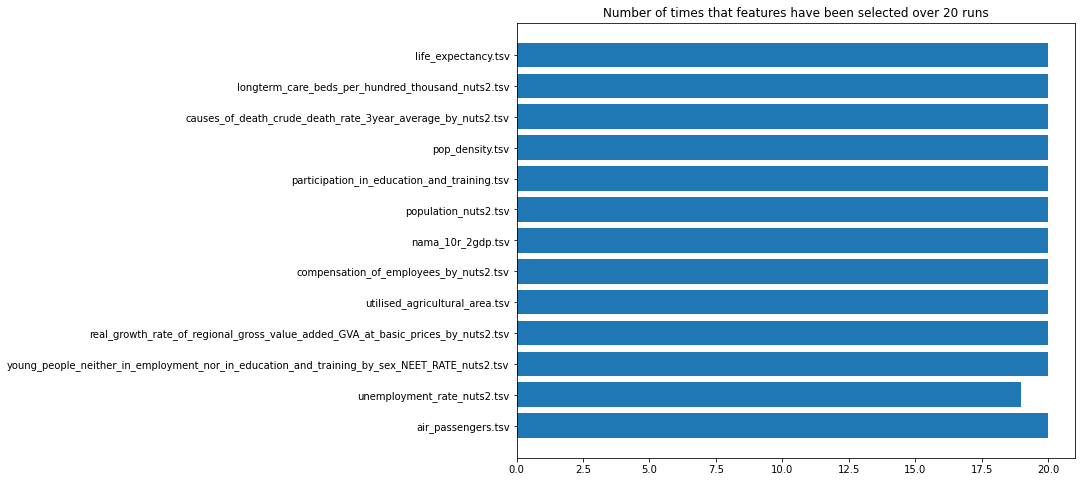

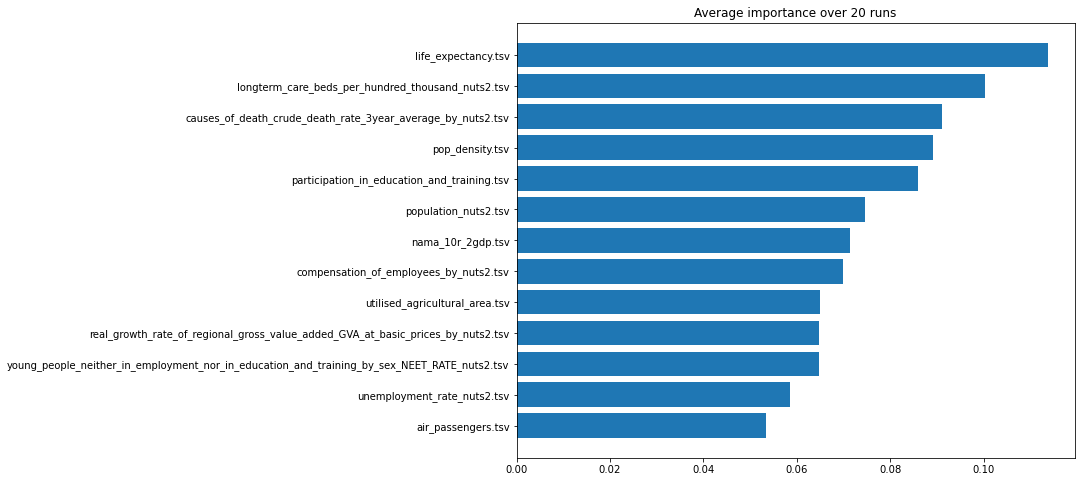

In [188]:
N_RUNS=20
import matplotlib.pyplot as plt
import os
RESULTS_DIR = "../../10_aug_lethality/"
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)
    
plt.figure(figsize=(10,8))
feature_importances = sorted(res.items(), key=lambda x: x[1][0])
used_feature_names = [ item[0]for item in feature_importances]
avg_importances = [ item[1][0] for item in feature_importances]
num_times_feature_is_selected = [ item[1][1] for item in feature_importances]
plt.title(F"Number of times that features have been selected over {N_RUNS} runs")
plt.barh(used_feature_names,num_times_feature_is_selected)
plt.savefig(RESULTS_DIR +target +"_numtimes", bbox_inches='tight', dpi=600)
plt.figure(figsize=(10,8))
plt.title(F"Average importance over {N_RUNS} runs")
plt.barh(used_feature_names,avg_importances)
plt.savefig(RESULTS_DIR +target +"_fimp", bbox_inches='tight', dpi=600)

# shap values


['air_passengers.tsv', 'causes_of_death_crude_death_rate_3year_average_by_nuts2.tsv', 'compensation_of_employees_by_nuts2.tsv', 'life_expectancy.tsv', 'longterm_care_beds_per_hundred_thousand_nuts2.tsv', 'nama_10r_2gdp.tsv', 'participation_in_education_and_training.tsv', 'population_nuts2.tsv', 'pop_density.tsv', 'real_growth_rate_of_regional_gross_value_added_GVA_at_basic_prices_by_nuts2.tsv', 'unemployment_rate_nuts2.tsv', 'utilised_agricultural_area.tsv', 'young_people_neither_in_employment_nor_in_education_and_training_by_sex_NEET_RATE_nuts2.tsv']


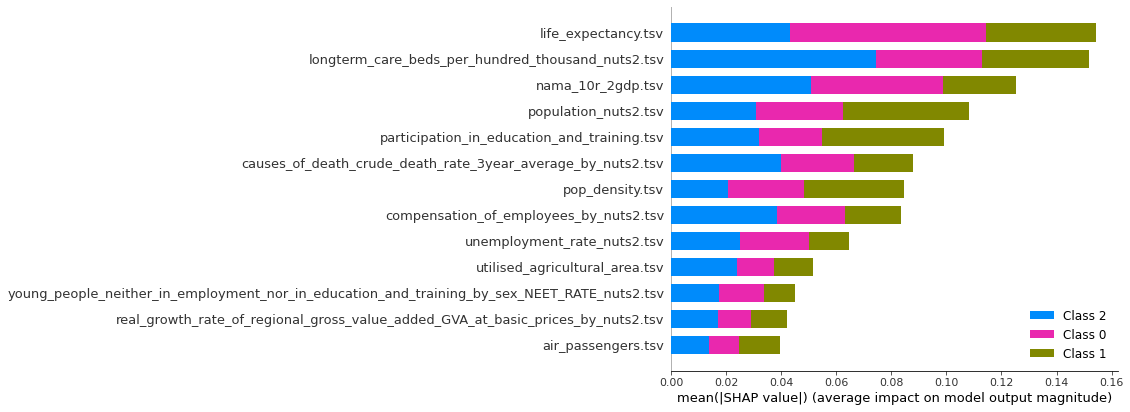

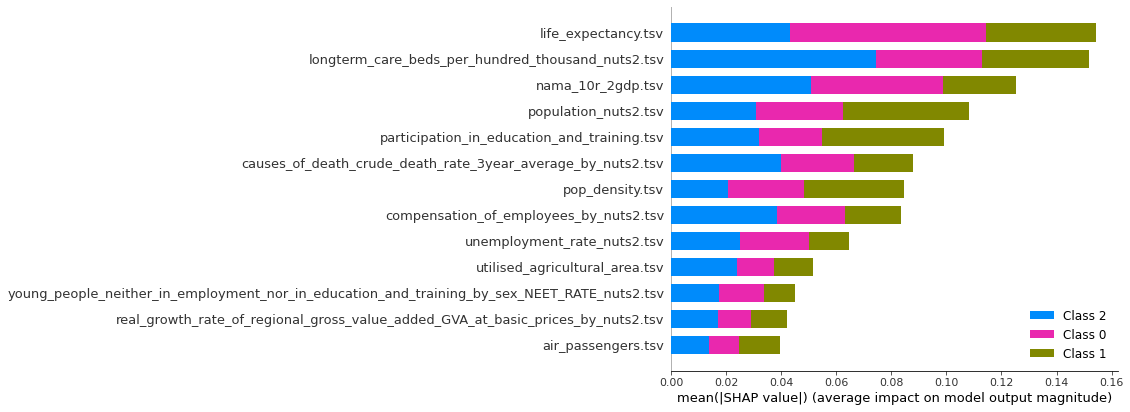

In [9]:
import shap
import matplotlib.pyplot as plt

selected_features = tm.X_train_full.columns[tm.pipeline["feature_selection"].get_support()].tolist()
print(selected_features)
shap_values = shap.TreeExplainer(tm.trained_model).shap_values(tm.X_train_full[selected_features])
shap.summary_plot(shap_values, tm.X_train_full[selected_features], plot_type="bar")

shap.summary_plot(shap_values, tm.X_train_full[selected_features])
#plt.title(F"SHAP values summary (target: {target})")
#plt.savefig("../../9_aug_new/" +target +"_shap", bbox_inches='tight', dpi=600)

# LIME

In [11]:
import lime
import lime.lime_tabular


explainer = lime.lime_tabular.LimeTabularExplainer(tm.X_train_full[selected_features].to_numpy(),
                        feature_names=selected_features, class_names=[target], verbose=True, mode='classification')

exp = explainer.explain_instance(tm.X_train_full[tm.X_train_full.index == "ITC4"][selected_features].values\
                                 .squeeze(), tm.trained_model.predict)
exp.show_in_notebook(show_table=True)
#exp = explainer.explain_instance(tm.X_test[tm.X_test.index == "ITC4"].values.squeeze(), tm.trained_model.predict)
#exp.show_in_notebook(show_table=True)

NotImplementedError: LIME does not currently support classifier models without probability scores. If this conflicts with your use case, please let us know: https://github.com/datascienceinc/lime/issues/16

In [ ]:
with open("lime_output.html", "w+", encoding="utf-8") as out:
    out.write(exp.as_html())
#exp.as_list()
exp.as_pyplot_figure()

In [14]:
lombardy_target_ground_truth = tm.y_train_full[tm.y_train_full.index == "ITC4"]